In [1]:
#import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import dataset
dataset = pd.read_csv('Interbank_rates.csv')
dataset.head()

,Rate Date,Weighted Average
0,11/6/2023,16.3
1,11/1/2023,18.0
2,10/26/2023,15.9
3,10/20/2023,5.8
4,10/13/2023,1.1


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rate Date         122 non-null    object 
 1   Weighted Average  122 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.0+ KB


In [4]:
# Convert 'Rate Date' to datetime format
dataset['Rate Date'] = pd.to_datetime(dataset['Rate Date'], format='%m/%d/%Y')

In [5]:
# Sort the DataFrame by 'Rate Date'
dataset = dataset.sort_values(by='Rate Date')

dataset.head()

,Rate Date,Weighted Average
121,2021-01-04,2.73
120,2021-01-14,1.78
119,2021-01-25,6.00
118,2021-02-01,12.30
117,2021-02-05,9.70


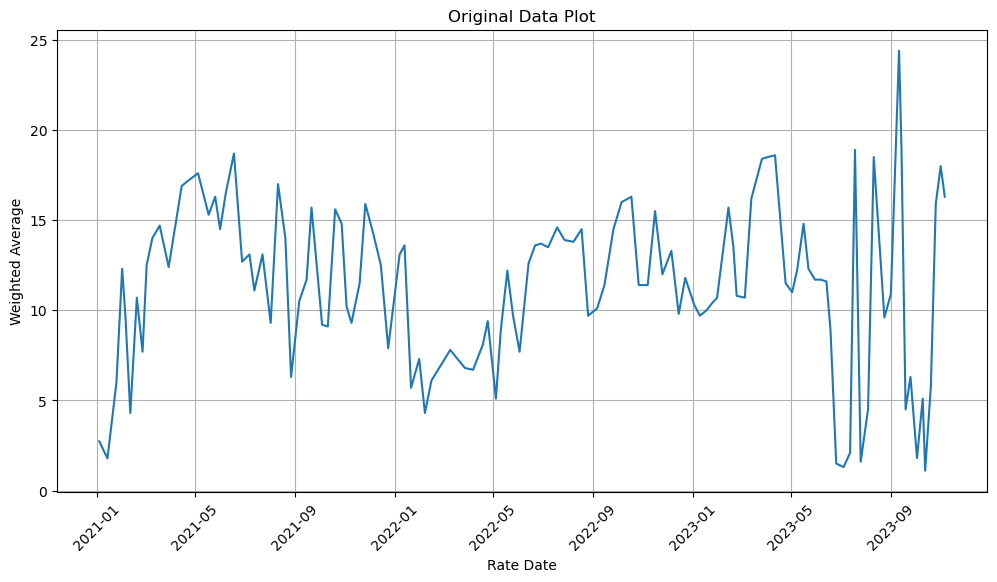

In [6]:
#Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(dataset['Rate Date'], dataset['Weighted Average'],  linestyle='-')
plt.title('Original Data Plot')
plt.xlabel('Rate Date')
plt.ylabel('Weighted Average')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [7]:
dataset.dropna(inplace=True)

In [8]:
# Shapiro-Wilk test for normality
from scipy.stats import shapiro
stat, p_value = shapiro(dataset['Weighted Average'])
print(f'Shapiro-Wilk Test Statistic: {stat}, p-value: {p_value}')

# Interpret the results
alpha = 0.05
if p_value > alpha:
    print("Data looks Gaussian (not significantly different from normal distribution)")
else:
    print("Data does not look Gaussian (significantly different from normal distribution)")


Shapiro-Wilk Test Statistic: 0.980216383934021, p-value: 0.07010278850793839
Data looks Gaussian (not significantly different from normal distribution)


In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

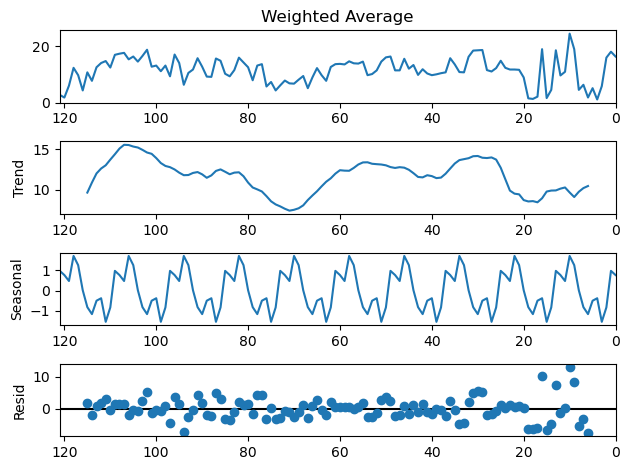

In [10]:
# Set 'Rate Date' as the index for time series analysis
#dataset.set_index('Rate Date', inplace=True)

# Perform time series decomposition
# Decomposition to check dataset component
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dataset['Weighted Average'], period = 12)
decomposition.plot()
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller

# Function to check and log stationarity
def check_stationarity(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    
    # Check for stationarity
    if result[1] <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary. Differencing is required.")

# Check stationarity of the original time series
check_stationarity(dataset['Weighted Average'])


ADF Statistic: -4.32296540185518
p-value: 0.00040524752789773493
Critical Values: {'1%': -3.4865346059036564, '5%': -2.8861509858476264, '10%': -2.579896092790057}
The time series is stationary.


In [12]:
dataset.columns

Index(['Rate Date', 'Weighted Average'], dtype='object')

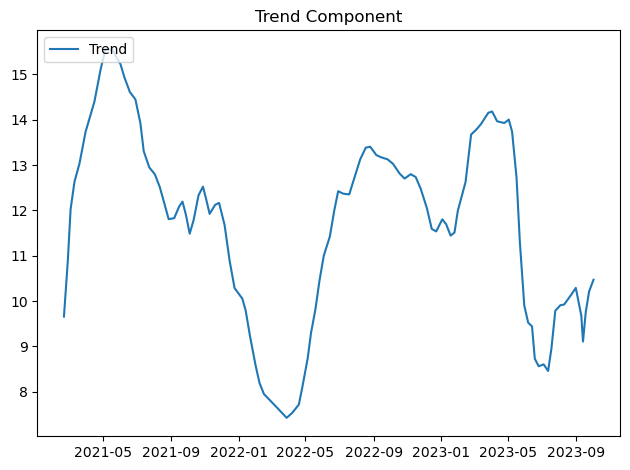

In [13]:
# Trend component
plt.plot(dataset['Rate Date'], decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.title('Trend Component')
plt.tight_layout()

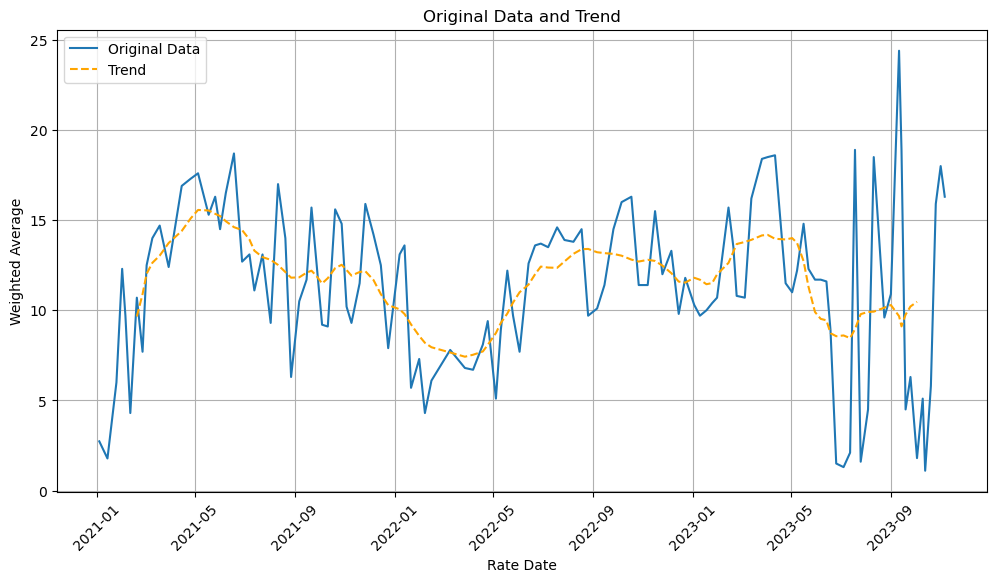

In [14]:
# Plot original data and trend
plt.figure(figsize=(12, 6))
plt.plot(dataset['Rate Date'], dataset['Weighted Average'], label='Original Data', linestyle='-')
plt.plot(dataset['Rate Date'], decomposition.trend, label='Trend', linestyle='--', color='orange')
plt.title('Original Data and Trend')
plt.xlabel('Rate Date')
plt.ylabel('Weighted Average')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

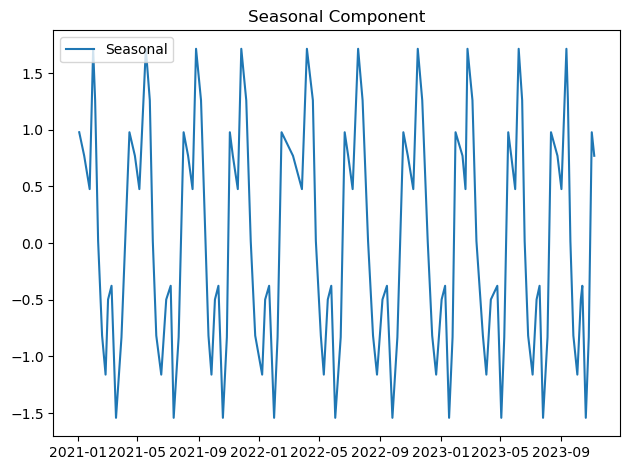

In [15]:
# Seasonal variatiom
plt.plot(dataset['Rate Date'],decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.title('Seasonal Component')
plt.tight_layout()

In [16]:
# Calculate autocovariance for lags 1 to 10
lags = range(1, 11)

In [17]:
# Calculate autocovariances
autocovariances = [np.cov(dataset['Weighted Average'][:-lag], dataset['Weighted Average'][lag:])[0, 1] for lag in lags]

In [18]:
# Display the autocovariances
for lag, autocovariance in zip(lags, autocovariances):
    print(f"Lag {lag}: {autocovariance}")

Lag 1: 10.003436818181816
Lag 2: 3.89256449579832
Lag 3: 4.504692066657172
Lag 4: 2.8761744169201795
Lag 5: 0.3620826702033605
Lag 6: -0.17302053973013545
Lag 7: -0.9466463768115944
Lag 8: -2.2109278062412665
Lag 9: 0.12488155815423493
Lag 10: -0.7901199324324323


In [19]:
from statsmodels.graphics.tsaplots import plot_acf

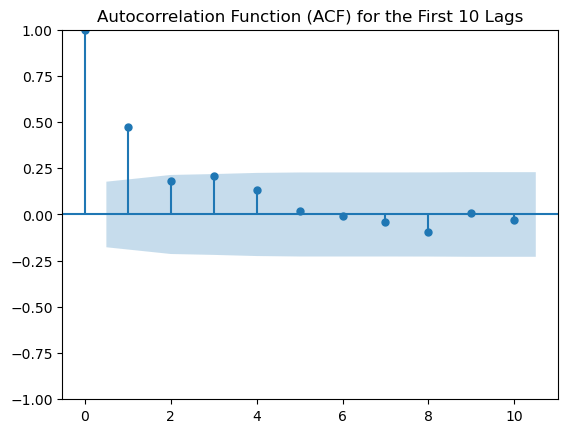

In [20]:
# Plot the ACF for the first 10 lags
plot_acf(dataset['Weighted Average'], lags=10)
plt.title('Autocorrelation Function (ACF) for the First 10 Lags')
plt.show()

In [21]:
from statsmodels.tsa.stattools import acf

In [22]:
# Calculate autocorrelation function
lags = 10  # Adjust the number of lags as needed
acf_values = acf(dataset['Weighted Average'], nlags=lags)

In [23]:
# Create a DataFrame for the autocorrelation values
acf_df = pd.DataFrame({
    'Lag': range(1, lags + 1),
    'Autocorrelation': acf_values[1:]
})

In [24]:
# Display the tabular form of the autocorrelation function
print(acf_df)

   Lag  Autocorrelation
0    1         0.475724
1    2         0.182931
2    3         0.209454
3    4         0.132604
4    5         0.016644
5    6        -0.007214
6    7        -0.041016
7    8        -0.096415
8    9         0.008957
9   10        -0.032438


In [25]:
from statsmodels.tsa.arima.model import ARIMA

In [26]:
import statsmodels.api as sm

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

In [27]:
model_ar1 = AutoReg(dataset['Weighted Average'], lags=1).fit()
model_ar2 = AutoReg(dataset['Weighted Average'], lags=2).fit()
model_ar3 = AutoReg(dataset['Weighted Average'], lags=3).fit()

C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [28]:
# Print summary and evaluate performance
print(model_ar1.summary())
print(model_ar2.summary())
print(model_ar3.summary())

                            AutoReg Model Results                             
Dep. Variable:       Weighted Average   No. Observations:                  122
Model:                     AutoReg(1)   Log Likelihood                -337.334
Method:               Conditional MLE   S.D. of innovations              3.931
Date:                Tue, 28 Nov 2023   AIC                            680.667
Time:                        18:43:49   BIC                            689.055
Sample:                             1   HQIC                           684.074
                                  122                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   6.0164      0.963      6.250      0.000       4.130       7.903
Weighted Average.L1     0.4805      0.079      6.109      0.000       0.326       0.635
                

In [29]:
# Calculate moving averages of order 1, 2, and 3
ma_order_1 = dataset[['Rate Date', 'Weighted Average']].rolling(window=1).mean()
ma_order_2 = dataset[['Rate Date', 'Weighted Average']].rolling(window=2).mean()
ma_order_3 = dataset[['Rate Date', 'Weighted Average']].rolling(window=3).mean()

In [30]:
ma_order_1.reset_index(drop=True, inplace=True)
ma_order_2.reset_index(drop=True, inplace=True)
ma_order_3.reset_index(drop=True, inplace=True)

In [31]:
y = dataset['Weighted Average']
order = 1  # You can adjust the order of the MA model
ma_model_1 = sm.tsa.SARIMAX(y, order=(0, 0, order), trend='c')  # MA order is specified as the `order` argument
ma_model_1 = ma_model_1.fit()
ma_model_1.summary()

C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Weighted Average   No. Observations:                  122
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -341.804
Date:                Tue, 28 Nov 2023   AIC                            689.608
Time:                        18:44:28   BIC                            698.020
Sample:                             0   HQIC                           693.025
                                - 122                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     11.3953      0.561     20.322      0.000      10.296      12.494
ma.L1          0.5122      0.067      7.672      0.000       0.381       0.643
sigma2        15.8469      1.712      9.256      0.000      12.491      19.202
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                16.82
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               2.26   Skew:                            -0.43
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
y = dataset['Weighted Average']
order = 2  # You can adjust the order of the MA model
ma_model_2 = sm.tsa.SARIMAX(y, order=(0, 0, order), trend='c')  # MA order is specified as the `order` argument
ma_model_2 = ma_model_2.fit()
ma_model_2.summary()

C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Weighted Average   No. Observations:                  122
Model:               SARIMAX(0, 0, 2)   Log Likelihood                -341.464
Date:                Tue, 28 Nov 2023   AIC                            690.928
Time:                        18:44:38   BIC                            702.144
Sample:                             0   HQIC                           695.484
                                - 122                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     11.3925      0.609     18.706      0.000      10.199      12.586
ma.L1          0.5385      0.084      6.414      0.000       0.374       0.703
ma.L2          0.0674      0.076      0.892      0.372      -0.081       0.215
sigma2        15.7590      1.742      9.048      0.000      12.345      19.173
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                18.25
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.36   Skew:                            -0.38
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
y = dataset['Weighted Average']
order = 3  # You can adjust the order of the MA model
ma_model_3 = sm.tsa.SARIMAX(y, order=(0, 0, order), trend='c')  # MA order is specified as the `order` argument
ma_model_3 = ma_model_3.fit()
ma_model_3.summary()

C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Weighted Average   No. Observations:                  122
Model:               SARIMAX(0, 0, 3)   Log Likelihood                -340.181
Date:                Tue, 28 Nov 2023   AIC                            690.362
Time:                        18:44:53   BIC                            704.382
Sample:                             0   HQIC                           696.056
                                - 122                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     11.3836      0.677     16.809      0.000      10.056      12.711
ma.L1          0.5133      0.080      6.398      0.000       0.356       0.671
ma.L2          0.1112      0.083      1.343      0.179      -0.051       0.273
ma.L3          0.1747      0.098      1.781      0.075      -0.018       0.367
sigma2        15.4212      1.791      8.609      0.000      11.910      18.932
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                15.23
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.22   Skew:                            -0.20
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
import statsmodels.api as sm
order = (1, 0, 1)  # (p, d, q) order of the ARIMA model
arma_model11 = sm.tsa.ARIMA(dataset['Weighted Average'].dropna(), order=order)
arma_model11 = arma_model11.fit()
print(arma_model11.summary())

C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       Weighted Average   No. Observations:                  122
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -341.193
Date:                Tue, 28 Nov 2023   AIC                            690.387
Time:                        18:45:29   BIC                            701.603
Sample:                             0   HQIC                           694.942
                                - 122                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.3879      0.666     17.091      0.000      10.082      12.694
ar.L1          0.2465      0.136      1.816      0.069      -0.020       0.512
ma.L1          0.3025      0.117      2.594      0.0

In [36]:
order = (1, 0, 2)  # (p, d, q) order of the ARIMA model
arma_model12 = sm.tsa.ARIMA(dataset['Weighted Average'].dropna(), order=order)
arma_model12 = arma_model12.fit()
print(arma_model12.summary())

C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       Weighted Average   No. Observations:                  122
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -340.108
Date:                Tue, 28 Nov 2023   AIC                            690.215
Time:                        18:45:48   BIC                            704.235
Sample:                             0   HQIC                           695.910
                                - 122                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.3548      0.835     13.595      0.000       9.718      12.992
ar.L1          0.7324      0.297      2.464      0.014       0.150       1.315
ma.L1         -0.1801      0.292     -0.617      0.5

In [37]:
order = (2, 0, 2)  # (p, d, q) order of the ARIMA model
arma_model22 = sm.tsa.ARIMA(dataset['Weighted Average'].dropna(), order=order)
arma_model22 = arma_model22.fit()
print(arma_model22.summary())

C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       Weighted Average   No. Observations:                  122
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -338.647
Date:                Tue, 28 Nov 2023   AIC                            689.294
Time:                        18:46:01   BIC                            706.118
Sample:                             0   HQIC                           696.127
                                - 122                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.3718      0.878     12.945      0.000       9.650      13.094
ar.L1         -0.0948      0.262     -0.362      0.718      -0.608       0.419
ar.L2          0.4726      0.103      4.576      0.0

In [38]:
order = (2, 0, 3)  # (p, d, q) order of the ARIMA model
arma_model23 = sm.tsa.ARIMA(dataset['Weighted Average'].dropna(), order=order)
arma_model23 = arma_model23.fit()
print(arma_model23.summary())

C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       Weighted Average   No. Observations:                  122
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -334.615
Date:                Tue, 28 Nov 2023   AIC                            683.230
Time:                        18:46:32   BIC                            702.859
Sample:                             0   HQIC                           691.203
                                - 122                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4530      0.777     14.738      0.000       9.930      12.976
ar.L1          1.4481      0.081     17.897      0.000       1.290       1.607
ar.L2         -0.8016      0.086     -9.296      0.0

C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [39]:
order = (1, 0, 3)  # (p, d, q) order of the ARIMA model
arma_model13 = sm.tsa.ARIMA(dataset['Weighted Average'].dropna(), order=order)
arma_model13 = arma_model13.fit()
print(arma_model13.summary())

C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       Weighted Average   No. Observations:                  122
Model:                 ARIMA(1, 0, 3)   Log Likelihood                -339.073
Date:                Tue, 28 Nov 2023   AIC                            690.146
Time:                        18:46:42   BIC                            706.970
Sample:                             0   HQIC                           696.979
                                - 122                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.3736      0.828     13.730      0.000       9.750      12.997
ar.L1          0.5657      0.317      1.786      0.074      -0.055       1.186
ma.L1         -0.0486      0.272     -0.179      0.8

In [40]:
order = (3, 0, 3)  # (p, d, q) order of the ARIMA model
arma_model33 = sm.tsa.ARIMA(dataset['Weighted Average'].dropna(), order=order)
arma_model33 = arma_model33.fit()
print(arma_model33.summary())

C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       Weighted Average   No. Observations:                  122
Model:                 ARIMA(3, 0, 3)   Log Likelihood                -334.899
Date:                Tue, 28 Nov 2023   AIC                            685.797
Time:                        18:46:55   BIC                            708.229
Sample:                             0   HQIC                           694.908
                                - 122                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.3465      0.726     15.620      0.000       9.923      12.770
ar.L1          1.0689      0.150      7.127      0.000       0.775       1.363
ar.L2         -0.9480      0.182     -5.210      0.0

C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [41]:
# Calculate AIC and BIC for each model
models = [model_ar1, model_ar2, model_ar3, ma_model_1, ma_model_2, ma_model_3, arma_model11, arma_model12, arma_model13, arma_model22, arma_model23, arma_model33]
orders = [(1, 0, 0), (2, 0, 0), (3, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3),(1, 0, 1), (1, 0, 2), (1, 0, 3), (2, 0, 2), (2, 0, 3), (3, 0, 3)]

In [42]:
for model, order in zip(models, orders):
    print(f"Order {order}: AIC={model.aic:.2f}, BIC={model.bic:.2f}")

Order (1, 0, 0): AIC=680.67, BIC=689.05
Order (2, 0, 0): AIC=675.82, BIC=686.97
Order (3, 0, 0): AIC=668.34, BIC=682.24
Order (0, 0, 1): AIC=689.61, BIC=698.02
Order (0, 0, 2): AIC=690.93, BIC=702.14
Order (0, 0, 3): AIC=690.36, BIC=704.38
Order (1, 0, 1): AIC=690.39, BIC=701.60
Order (1, 0, 2): AIC=690.22, BIC=704.24
Order (1, 0, 3): AIC=690.15, BIC=706.97
Order (2, 0, 2): AIC=689.29, BIC=706.12
Order (2, 0, 3): AIC=683.23, BIC=702.86
Order (3, 0, 3): AIC=685.80, BIC=708.23


In [43]:
# Choose the model with the lowest AIC
best_model = models[np.argmin([model.aic for model in models])]
print("Best Model:", best_model)

Best Model: <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x00000165A4642D60>


In [44]:
best_model.aic

668.3395803937985

In [45]:
best_model.bic

682.2351978593562

In [46]:
#Our best model is order (3,0,0) i.e AR3

# AR(3,0,0) Model
best_model = model_ar3

In [47]:
best_model

model_ar3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:       Weighted Average   No. Observations:                  122
Model:                     AutoReg(3)   Log Likelihood                -329.170
Method:               Conditional MLE   S.D. of innovations              3.847
Date:                Tue, 28 Nov 2023   AIC                            668.340
Time:                        18:48:19   BIC                            682.235
Sample:                             3   HQIC                           673.982
                                  122                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.4124      1.243      4.355      0.000       2.977       7.848
Weighted Average.L1     0.4838      0.090      5.384      0.000       0.308       0.660
Weighted Average.L2    -0.1398      0.099     -1.410      0.158      -0.334       0.055
Weighted Average.L3     0.1961      0.089      2.214      0.027       0.023       0.370
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4458           -0.0000j            1.4458           -0.0000
AR.2           -0.3664           -1.8418j            1.8779           -0.2813
AR.3           -0.3664           +1.8418j            1.8779            0.2813
-----------------------------------------------------------------------------
"""

In [48]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import normaltest

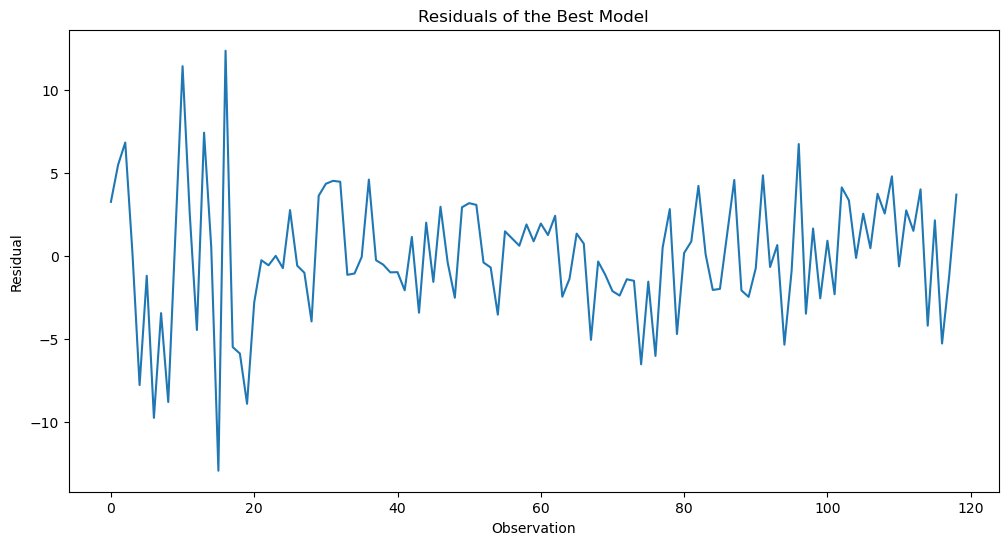

In [49]:
residuals = best_model.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals of the Best Model')
plt.xlabel('Observation')
plt.ylabel('Residual')
plt.show()

In [51]:
#Ljung-Box Test for Autocorrelation
lags = min(10, len(residuals) // 2)
acorr_ljungbox(residuals, lags=lags)

,lb_stat,lb_pvalue
1,0.027334,0.868684
2,0.079671,0.960947
3,0.234976,0.971755
4,0.273613,0.991453
5,0.908358,0.969614
6,1.151140,0.979229
7,1.297158,0.988515
8,3.911783,0.864994
9,6.020468,0.737868
10,6.596923,0.762871


In [52]:
#Normality Test
stat, p_value = normaltest(residuals)
print(f"Normality Test Result: Statistic={stat}, p-value={p_value}")
if p_value > 0.05:
    print("Residuals appear to be normally distributed.")
else:
    print("Residuals do not appear to be normally distributed.")

Normality Test Result: Statistic=6.776745200852554, p-value=0.033763579047738745
Residuals do not appear to be normally distributed.


In [53]:
#To test the parameter of the best ARIMA model
model_ar3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:       Weighted Average   No. Observations:                  122
Model:                     AutoReg(3)   Log Likelihood                -329.170
Method:               Conditional MLE   S.D. of innovations              3.847
Date:                Tue, 28 Nov 2023   AIC                            668.340
Time:                        18:49:56   BIC                            682.235
Sample:                             3   HQIC                           673.982
                                  122                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.4124      1.243      4.355      0.000       2.977       7.848
Weighted Average.L1     0.4838      0.090      5.384      0.000       0.308       0.660
Weighted Average.L2    -0.1398      0.099     -1.410      0.158      -0.334       0.055
Weighted Average.L3     0.1961      0.089      2.214      0.027       0.023       0.370
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4458           -0.0000j            1.4458           -0.0000
AR.2           -0.3664           -1.8418j            1.8779           -0.2813
AR.3           -0.3664           +1.8418j            1.8779            0.2813
-----------------------------------------------------------------------------
"""

In [54]:
# Forecast future values
forecast_steps = 10  # Change this to the number of steps you want to forecast
forecast_values = best_model.predict(start=len(dataset), end=len(dataset) + forecast_steps - 1)

C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [55]:
# Create a new date range for the forecasted values
forecast_index = pd.date_range(start=dataset['Rate Date'].max(), periods=forecast_steps, freq='D')

In [56]:
# Set the new index for the forecasted values
forecast_values.index = forecast_index

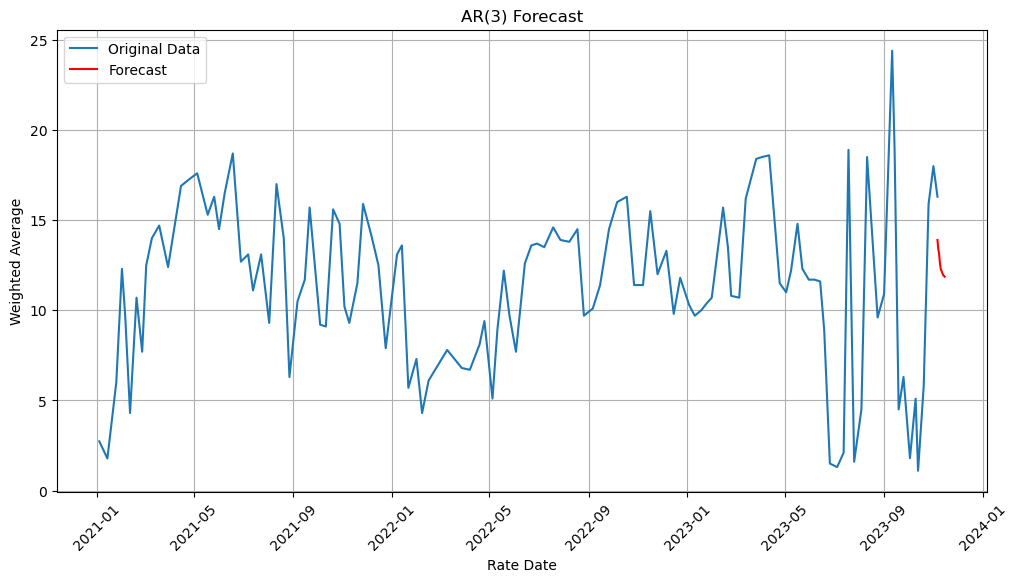

In [57]:
# Plot the original time series and the forecast
plt.figure(figsize=(12, 6))
plt.plot(dataset['Rate Date'], dataset['Weighted Average'], label='Original Data', linestyle='-')
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='red')
plt.title('AR(3) Forecast')
plt.xlabel('Rate Date')
plt.ylabel('Weighted Average')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [58]:
import statsmodels.api as sm

In [59]:
# Display the summary statistics
print("Summary Statistics for the Best ARIMA Model:")
print(best_model.summary())

Summary Statistics for the Best ARIMA Model:
                            AutoReg Model Results                             
Dep. Variable:       Weighted Average   No. Observations:                  122
Model:                     AutoReg(3)   Log Likelihood                -329.170
Method:               Conditional MLE   S.D. of innovations              3.847
Date:                Tue, 28 Nov 2023   AIC                            668.340
Time:                        18:51:14   BIC                            682.235
Sample:                             3   HQIC                           673.982
                                  122                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.4124      1.243      4.355      0.000       2.977       7.848
Weighted Average.L1     0.4838      0.090      5.384      0

In [60]:
# Forecast future values
forecast_steps = 10  # Change this to the number of steps you want to forecast
forecast_values = best_model.predict(start=len(dataset), end=len(dataset) + forecast_steps - 1)

C:\Users\EVTHAG\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [61]:
# Create a new date range for the forecasted values
forecast_index = pd.date_range(start=dataset['Rate Date'].max(), periods=forecast_steps, freq='D')

In [62]:
# Set the new index for the forecasted values
forecast_values.index = forecast_index

In [63]:
# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame({
    'Date': forecast_values.index,
    'Forecasted Value': forecast_values
})

In [64]:
# Display the forecasted values in tabular form
print(forecast_df)

                 Date  Forecasted Value
2023-11-06 2023-11-06         13.900543
2023-11-07 2023-11-07         13.389185
2023-11-08 2023-11-08         13.143882
2023-11-09 2023-11-09         12.626083
2023-11-10 2023-11-10         12.309555
2023-11-11 2023-11-11         12.180701
2023-11-12 2023-11-12         12.061060
2023-11-13 2023-11-13         11.959109
2023-11-14 2023-11-14         11.901238
2023-11-15 2023-11-15         11.864029
